In [145]:
import sys,os
import pylab as py
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import leastsq,minimize,root
from scipy.integrate import quad,fixed_quad, simps, dblquad
import pandas as pd
from tools import save,load,tex,ProgressBar,com,fill_between
from  matplotlib import rc
import matplotlib.gridspec as gridspec
%matplotlib inline  
%config InlineBacend.figure_format = 'retina' 
rc('font',**{'family':'sans-serif','sans-serif':['Times-Roman']})
rc('text',usetex=True)
#import lhapdf
from numpy import linalg as LA
from scipy.interpolate import interp1d
import pandas as pd
tex = lambda x: r'$\mathrm{'+x+'}$'

scale="10K" #1, 10, 100, 1K, 5K, 10K

## tensor charges

In [146]:
def get_data(fname):
  F=open(fname)
  L=F.readlines()
  F.close()
  L=[l.strip() for l in L]
  L=[l for l in L if l!='']
  L=[[float(x) for x in l.split()] for l in L]
  DF0=pd.DataFrame(L)
  DF=DF0.iloc[:, 0:7]
  DF.columns=['id','ChiSQ','Weight','full_int_deltaU','full_int_deltaD','trun_int_deltaU','trun_int_deltaD']
  #DF=pd.DataFrame(L,columns=columns)
  DF=DF[DF.full_int_deltaU>0]
  return DF

def plot(col,target,fs):
  f0='scale_cov_1/f1_weight_%s_%s_%s_1.dat'%(col,target,fs)
  f1='scale_cov_%s/f%s_weight_%s_%s_%s_1.dat'%(scale,scale,col,target,fs)
  dataI=get_data(f0)
  dataII=get_data(f1)
  
  nrows,ncols=4,2
  plt.figure(figsize=(ncols*5,nrows*2))
  ###############################
  ax=plt.subplot(nrows,ncols,1)
  ax.hist(dataI.ChiSQ,histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Yellow')
  ax.set_xlabel('$\chi^2$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,2)
  ax.hist(dataII.ChiSQ,histtype='stepfilled',bins=40,normed=0,range=None,facecolor='b',alpha=0.3)
  ax.set_xlabel('$\chi^2$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,3)
  ax.hist(dataI.Weight,histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Yellow')
  ax.set_xlabel('$w$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,4)
  ax.hist(dataII.Weight,histtype='stepfilled',bins=40,normed=0,range=None,facecolor='b',alpha=0.3)
  ax.set_xlabel('$w$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,5)
  ax.hist(dataI.trun_int_deltaU,histtype='stepfilled',bins=40,normed=0,facecolor='Yellow')
  ax.set_xlabel('$\Delta u$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,6)
  ax.hist(dataII.trun_int_deltaU,histtype='stepfilled',bins=40,normed=1,facecolor='b',alpha=0.2)
  w=dataII.Weight
  ax.hist(dataII.trun_int_deltaU,histtype='stepfilled',weights=w,bins=40,normed=1,facecolor='r',alpha=0.2)
  ax.set_xlabel('$\Delta u$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,7)
  ax.hist(dataI.trun_int_deltaD,histtype='stepfilled',bins=40,normed=0,facecolor='Yellow')
  ax.set_xlabel('$\Delta d$',size=20)
  ###############################
  ax=plt.subplot(nrows,ncols,8)
  ax.hist(dataII.trun_int_deltaD,histtype='stepfilled',bins=40,normed=1,facecolor='b',alpha=0.2)
  w=dataII.Weight
  ax.hist(dataII.trun_int_deltaD,histtype='stepfilled',weights=w,bins=40,normed=1,facecolor='r',alpha=0.2)
  ax.set_xlabel('$\Delta d$',size=20)  

  plt.tight_layout()
  plt.savefig("tensor_%s_%s_%s_f%s.png"%(col,target,fs,scale))

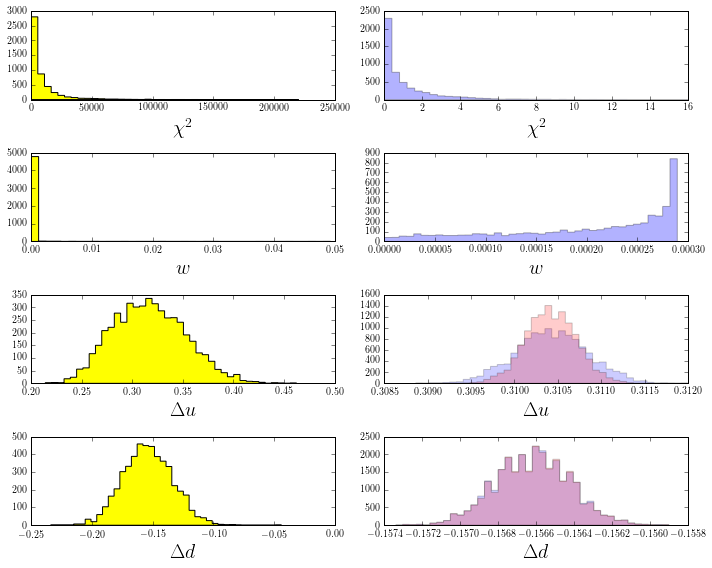

In [147]:
plot('clas','p','pip')

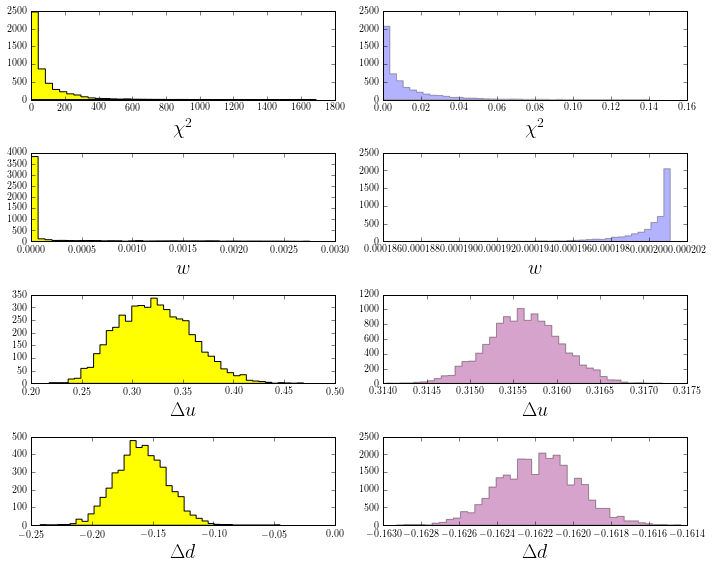

In [148]:
plot('clas','p','pim')

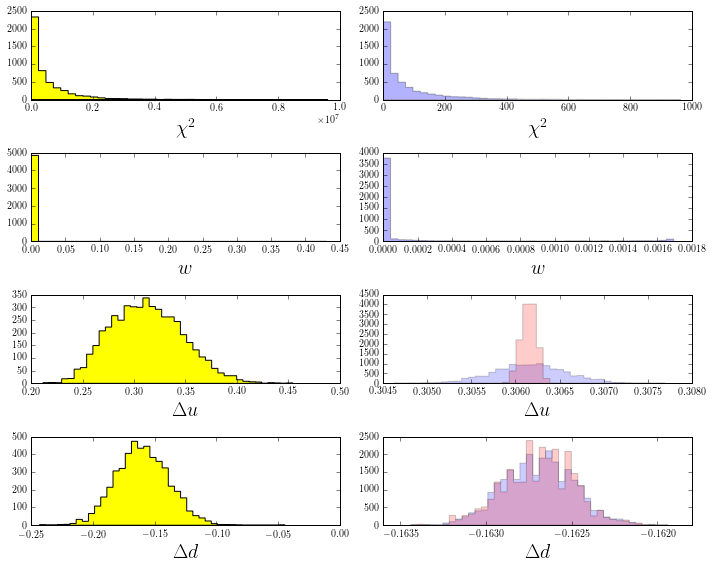

In [149]:
plot('solid','p','pip')

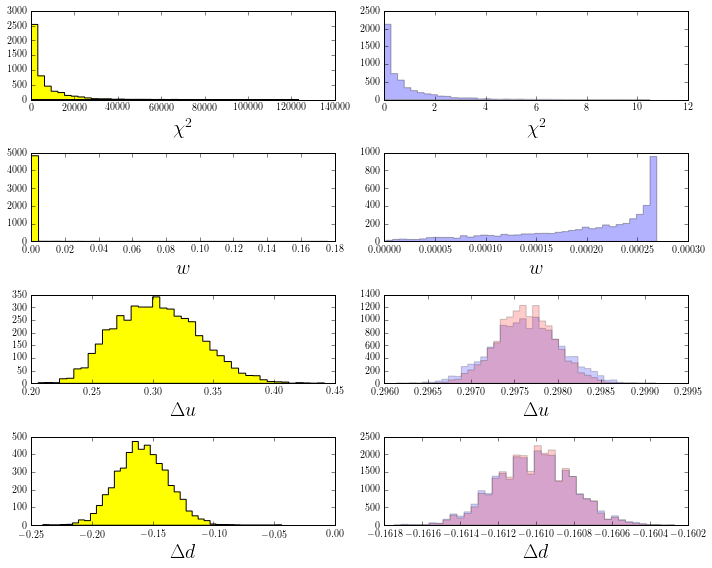

In [150]:
plot('solid','p','pim')

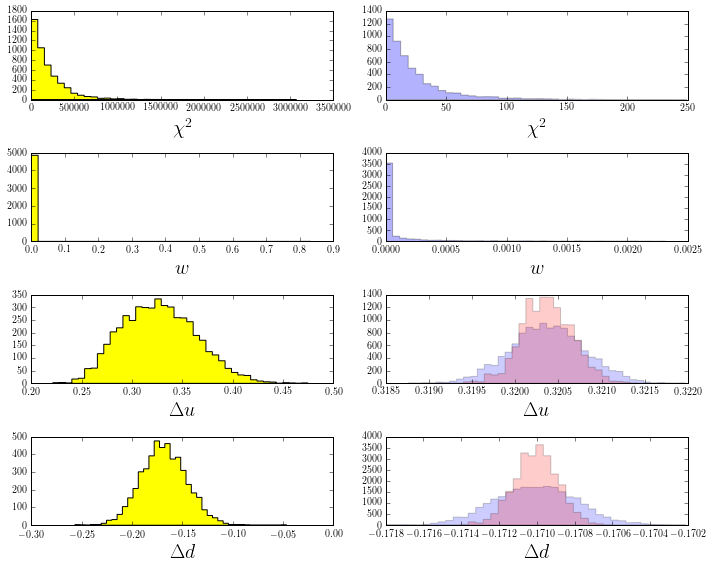

In [151]:
plot('solid','3he','pip')

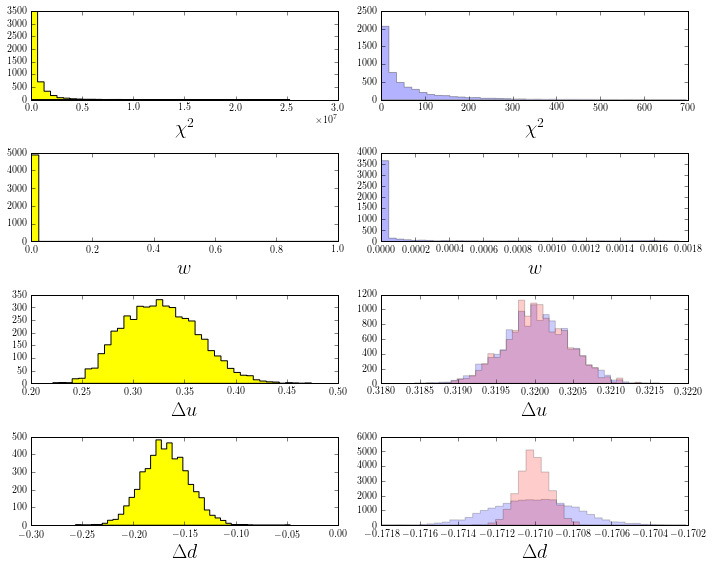

In [152]:
plot('solid','3he','pim')

# Summary

In [153]:
def reweight1(s1,s2,w):
  STD1=np.std(s1)
  E2=np.mean(s2)
  STD2=np.sum(w*(s2-E2)**2)**0.5
  return {'STD1':STD1,'STD2':STD2,'R':(STD2/STD1)}
  
def reweight2(col,target,fs,flav):
  f0='scale_cov_1/f1_weight_%s_%s_%s_1.dat'%(col,target,fs)
  f1='scale_cov_%s/f%s_weight_%s_%s_%s_1.dat'%(scale,scale,col,target,fs)
  dataI=get_data(f0)
  dataII=get_data(f1)
  s1=dataI['trun_int_delta%s'%flav]
  s2=dataII['trun_int_delta%s'%flav]
  w=dataII.Weight
  return reweight1(s1,s2,w)

def reweight3(col,target,fs):
  U=reweight2(col,target,fs,'U')
  D=reweight2(col,target,fs,'D')
  L=[]
  L.append(col)
  L.append(target)
  L.append(fs)
  L.append('%0.2e'%U['STD1'])
  L.append('%0.2e'%U['STD2'])
  L.append('%0.2e'%U['R'])
  L.append('%0.2e'%D['STD1'])
  L.append('%0.2e'%D['STD2'])
  L.append('%0.2e'%D['R'])
  return L

data=[]
data.append(reweight3('clas','p','pip'))
data.append(reweight3('clas','p','pim'))
data.append(reweight3('solid','p','pip'))
data.append(reweight3('solid','p','pim'))
data.append(reweight3('solid','3he','pip'))
data.append(reweight3('solid','3he','pim'))

pd.DataFrame(data,columns=['exp','tar','fs','std(U)','RWstd(U)','Rat(U)','std(D)','RWstd(D)','Rat(D)'])


,exp,tar,fs,std(U),RWstd(U),Rat(U),std(D),RWstd(D),Rat(D)
0,clas,p,pip,3.58e-02,2.94e-04,8.21e-03,2.03e-02,1.99e-04,9.83e-03
1,clas,p,pim,3.63e-02,4.23e-04,1.17e-02,2.11e-02,2.07e-04,9.81e-03
2,solid,p,pip,3.50e-02,8.62e-05,2.46e-03,2.13e-02,2.08e-04,9.77e-03
3,solid,p,pim,3.41e-02,3.31e-04,9.71e-03,2.10e-02,1.96e-04,9.32e-03
4,solid,3he,pip,3.67e-02,2.92e-04,7.96e-03,2.26e-02,1.16e-04,5.16e-03
5,solid,3he,pim,3.66e-02,4.05e-04,1.11e-02,2.26e-02,8.24e-05,3.64e-03


## Transversity

In [154]:
def get_dataII(fname):  
  F=open(fname)
  L=F.readlines()
  F.close()
  L=[l.strip() for l in L]
  L=[l for l in L if l!='']
  L=[[float(x) for x in l.split()] for l in L]
  L2=[]
  for l in L:
    chi2=l[1]
    w=l[2]
    data=l[7:]
    N=len(data)
    x =[data[3*i] for i in range(N/3) ]
    t1=[data[3*i+1] for i in range(N/3) ]
    t2=[data[3*i+2] for i in range(N/3) ]
    if t2[10]==0: continue
    L2.append([chi2,w,x,t1,t2])
  return pd.DataFrame(L2,columns=['chi2','weight','x','t1','t2'])


In [155]:
def plot(col,target,fs):
  nrows,ncols=2,2
  plt.figure(figsize=(ncols*4,nrows*3))

  f0='scale_cov_1/f1_weight_%s_%s_%s_1.dat'%(col,target,fs)
  f1='scale_cov_%s/f%s_weight_%s_%s_%s_1.dat'%(scale,scale,col,target,fs)
  DF=get_dataII(f0)
  RDF=get_dataII(f1)
    
  ax=plt.subplot(nrows,ncols,1)
  E=np.mean([DF.t1[i] for i in DF.index],axis=0)
  STD=np.std([DF.t1[i] for i in DF.index],axis=0)
  RE=np.sum([RDF.weight[i]*np.array(RDF.t1[i]) for i in RDF.index],axis=0)
  RSTD=np.sum([RDF.weight[i]*(np.array(RDF.t1[i])-RE)**2 for i in RDF.index],axis=0)**0.5
  #p2=fill_between(DF.x[0],E-STD,E+STD,ax=ax,facecolor='r',edgecolor='r',alpha=0.2)
  p2=plt.fill_between(DF.x[0],E-STD,E+STD,facecolor='r',edgecolor='r',alpha=0.2)
  p1,=ax.plot(DF.x[0],E,'r-')
  #rp2=fill_between(RDF.x[0],RE-RSTD,RE+RSTD,ax=ax,facecolor='b',edgecolor='b',alpha=0.2)
  rp2=plt.fill_between(RDF.x[0],RE-RSTD,RE+RSTD,facecolor='b',edgecolor='b',alpha=0.2)
  rp1,=ax.plot(RDF.x[0],RE,'b-')
  ax.set_ylabel('$x\Delta_T u$',size=20)
  ax.set_xlabel('$x$',size=20)

  ax=plt.subplot(nrows,ncols,2)
  E=np.mean([DF.t2[i] for i in DF.index],axis=0)
  STD=np.std([DF.t2[i] for i in DF.index],axis=0)
  RE=np.sum([RDF.weight[i]*np.array(RDF.t2[i]) for i in RDF.index],axis=0)
  RSTD=np.sum([RDF.weight[i]*(np.array(RDF.t2[i])-RE)**2 for i in RDF.index],axis=0)**0.5
  plt.fill_between(DF.x[0],E-STD,E+STD,facecolor='r',edgecolor='r',alpha=0.2)
  #fill_between(DF.x[0],E-STD,E+STD,ax=ax,facecolor='r',edgecolor='r',alpha=0.2)
  ax.plot(DF.x[0],E,'r-')
  plt.fill_between(RDF.x[0],RE-RSTD,RE+RSTD,facecolor='b',edgecolor='b',alpha=0.2)
  #fill_between(RDF.x[0],RE-RSTD,RE+RSTD,ax=ax,facecolor='b',edgecolor='b',alpha=0.2)
  ax.plot(RDF.x[0],RE,'b-')
  ax.set_ylabel('$x\Delta_T d$',size=20)
  ax.set_xlabel('$x$',size=20)
  ax.legend([(p2,p1),(rp2,rp1)],[tex('prior'),tex('posterrior')],fontsize=15,loc=4)

  ax=plt.subplot(nrows,ncols,3)
  E=np.mean([DF.t1[i] for i in DF.index],axis=0)
  STD=np.std([DF.t1[i] for i in DF.index],axis=0)
  RE=np.sum([RDF.weight[i]*np.array(RDF.t1[i]) for i in RDF.index],axis=0)
  RSTD=np.sum([RDF.weight[i]*(np.array(RDF.t1[i])-RE)**2 for i in RDF.index],axis=0)**0.5
  ax.plot(RDF.x[0],RSTD/STD,'k-')
  ax.set_ylabel(r'$\bar{\sigma_u}/\sigma_u$',size=20)
  ax.set_xlabel('$x$',size=20)
  ax.set_ylim(0,0.06)

  ax=plt.subplot(nrows,ncols,4)
  E=np.mean([DF.t2[i] for i in DF.index],axis=0)
  STD=np.std([DF.t2[i] for i in DF.index],axis=0)
  RE=np.sum([RDF.weight[i]*np.array(RDF.t2[i]) for i in RDF.index],axis=0)
  RSTD=np.sum([RDF.weight[i]*(np.array(RDF.t2[i])-RE)**2 for i in RDF.index],axis=0)**0.5
  ax.plot(RDF.x[0],RSTD/STD,'k-')
  ax.set_ylabel(r'$\bar{\sigma_d}/\sigma_d$',size=20)
  ax.set_xlabel('$x$',size=20)
  ax.set_ylim(0,0.06)
  
  plt.tight_layout()
  plt.savefig("transversity_%s_%s_%s_f%s.png"%(col,target,fs,scale))

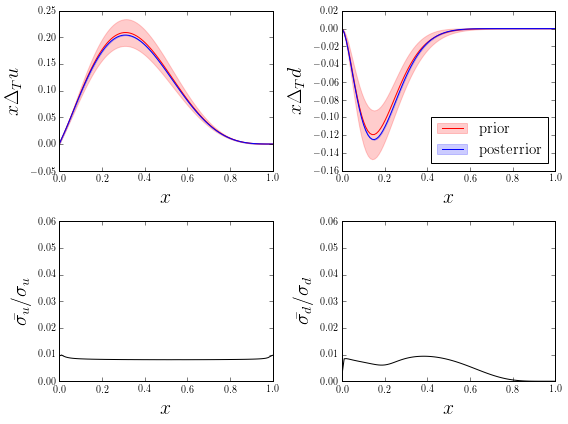

In [156]:
plot('clas','p','pip')

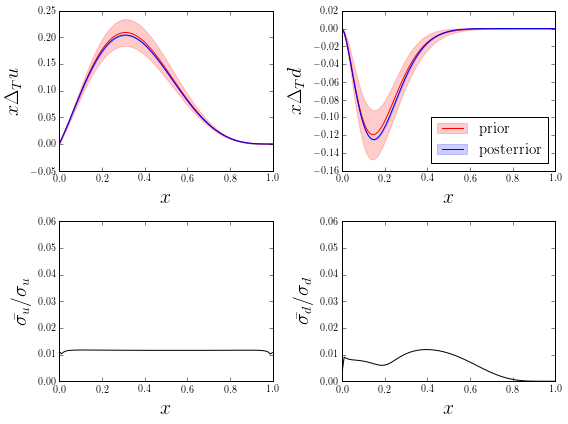

In [157]:
plot('clas','p','pim')

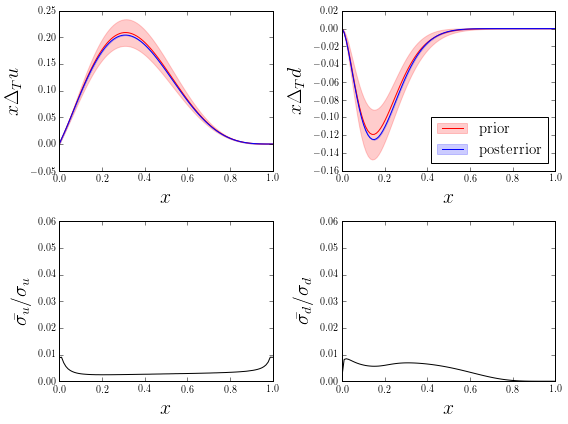

In [158]:
plot('solid','p','pip')

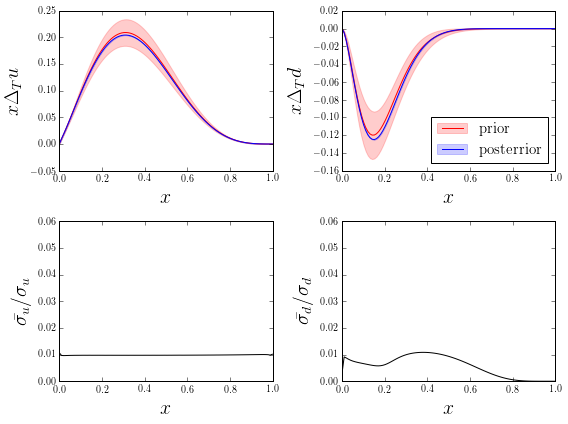

In [159]:
plot('solid','p','pim')

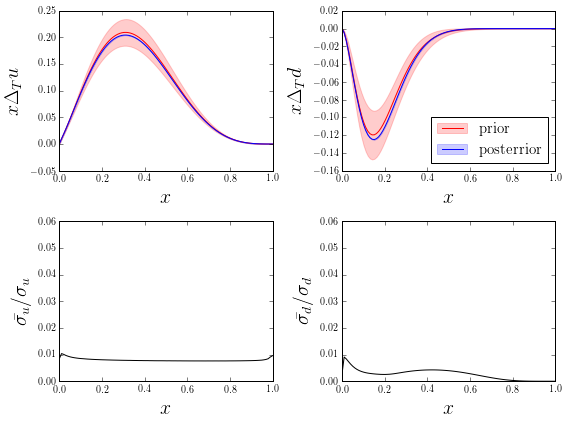

In [160]:
plot('solid','3he','pip')

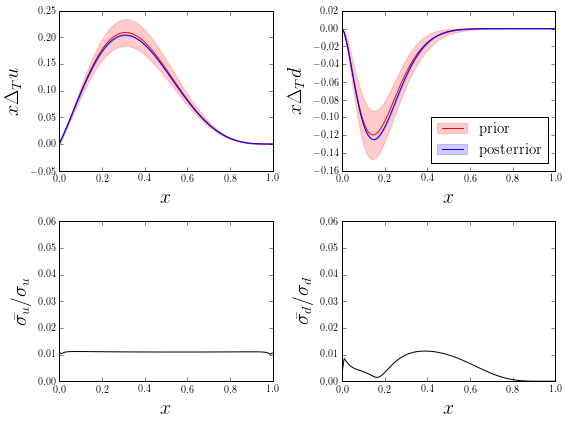

In [161]:
plot('solid','3he','pim')

In [121]:
def plotII(col,target,fs):
  nrows,ncols=2,2
  plt.figure(figsize=(ncols*4,nrows*3))

  f0='scale_cov_1/f1_weight_%s_%s_%s_1.dat'%(col,target,fs)
  f1='scale_cov_%s/f%s_weight_%s_%s_%s_1.dat'%(scale,scale,col,target,fs)
  DF=get_dataII(f0)
  RDF=get_dataII(f1)
  
  ax=plt.subplot(nrows,ncols,1)
  ax.hist([DF.t1[i][10] for i in DF.index],histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Yellow')
  ax.hist([RDF.t1[i][10] for i in RDF.index],histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Blue')
  ax.set_xlabel('$x\Delta_T u$',size=20)

  ax=plt.subplot(nrows,ncols,2)
  ax.hist([DF.t2[i][10] for i in DF.index],histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Yellow')
  ax.hist([RDF.t2[i][10] for i in RDF.index],histtype='stepfilled',bins=40,normed=0,range=None,facecolor='Blue')
  ax.set_xlabel('$x\Delta_T u$',size=20)


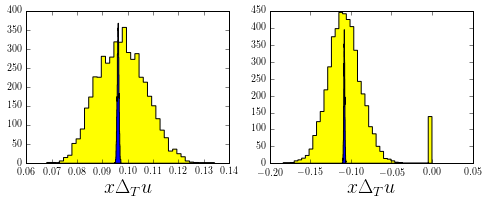

In [122]:
plotII("solid","3he","pip")

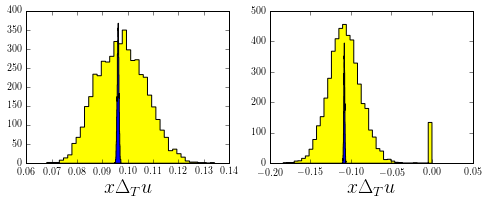

In [123]:
plotII("solid","3he","pim")

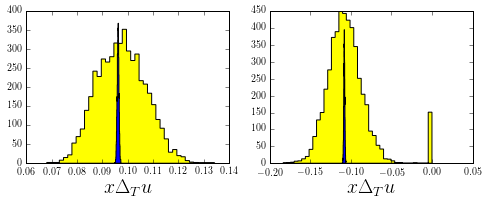

In [124]:
plotII("solid","p","pip")

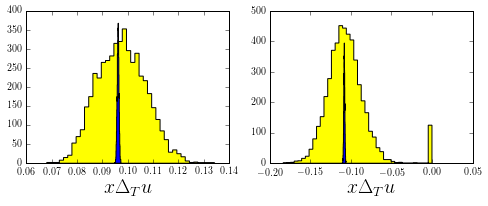

In [125]:
plotII("solid","p","pim")

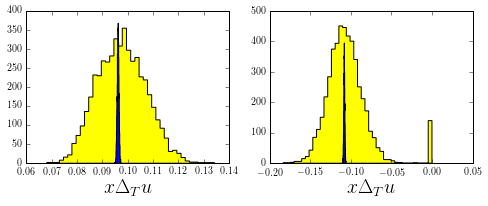

In [126]:
plotII("clas","p","pip")

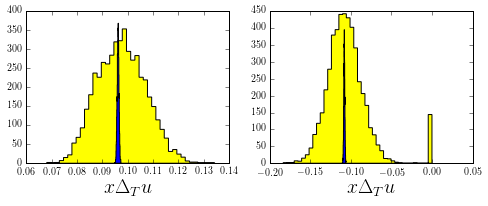

In [127]:
plotII("clas","p","pim")